<h1 style="text-align: center;">Test the effect of pandemic on the volatility in different countries</h1>

## 1. Exploratory data analysis

In [3]:
# pip install yfinance --upgrade

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Download data for S&P 500 and CAC 40
start_date = '2015-01-01'
end_date = '2024-12-31'
tickers = {'S&P500': '^GSPC', 'CAC40': '^FCHI'}

data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df[['Close']].rename(columns={'Close': 'Price'})
    df['LogReturn'] = np.log(df['Price'] / df['Price'].shift(1))
    df.dropna(inplace=True)
    data[name] = df

C:\Users\Manuel\AppData\Local\Temp\ipykernel_21700\1656921792.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Manuel\AppData\Local\Temp\ipykernel_21700\1656921792.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



===== S&P500 Descriptive Statistics (2015-2024) =====
count    2514.000000
mean        0.000419
std         0.011272
min        -0.127652
25%        -0.003780
50%         0.000639
75%         0.005740
max         0.089683
Name: LogReturn, dtype: float64


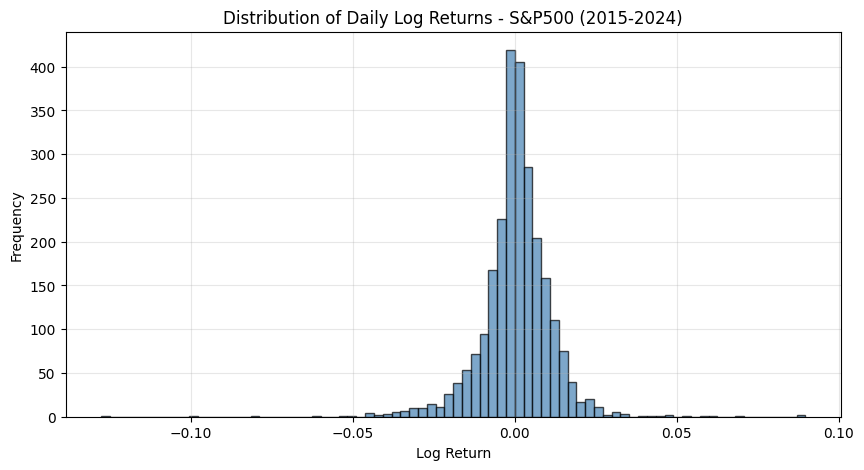


===== CAC40 Descriptive Statistics (2015-2024) =====
count    2558.000000
mean        0.000212
std         0.011845
min        -0.130983
25%        -0.005061
50%         0.000735
75%         0.006145
max         0.080561
Name: LogReturn, dtype: float64


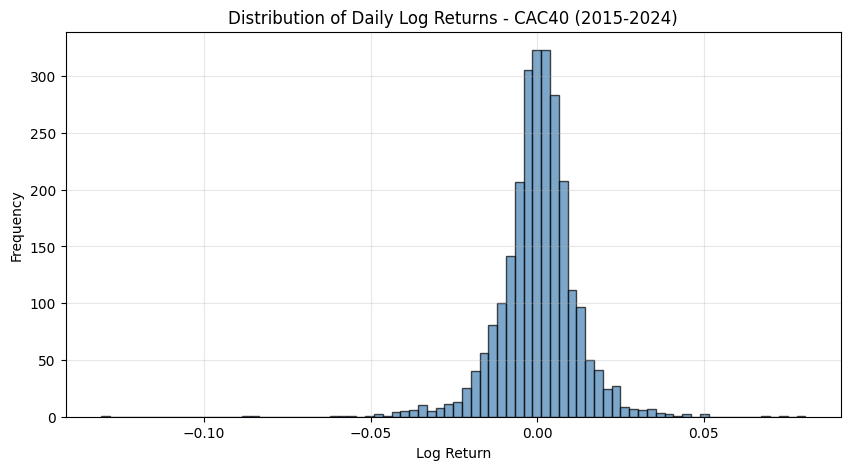

In [6]:
# Descriptive statistics and first visual check
for name, df in data.items():
    print(f"\n===== {name} Descriptive Statistics (2015-2024) =====")
    print(df['LogReturn'].describe())

    plt.figure(figsize=(10,5))
    plt.hist(df['LogReturn'], bins=80, alpha=0.7, color='steelblue', edgecolor='k')
    plt.title(f"Distribution of Daily Log Returns - {name} (2015-2024)")
    plt.xlabel("Log Return")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    # plt.savefig(f"{name}_hist.png", dpi=300, bbox_inches='tight')
    plt.show()

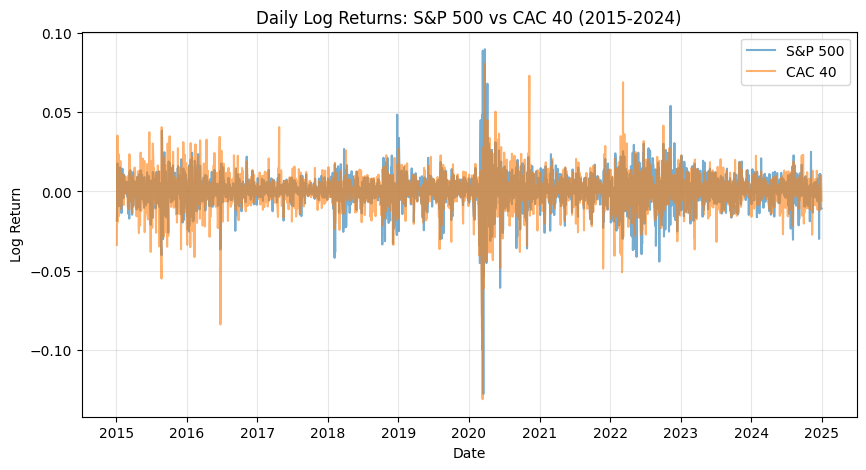

In [8]:
# Compare both time series visually
plt.figure(figsize=(10,5))
plt.plot(data['S&P500'].index, data['S&P500']['LogReturn'], label='S&P 500', alpha=0.6)
plt.plot(data['CAC40'].index, data['CAC40']['LogReturn'], label='CAC 40', alpha=0.6)
plt.title('Daily Log Returns: S&P 500 vs CAC 40 (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig("plot_log.png", dpi=300, bbox_inches='tight')
plt.show()

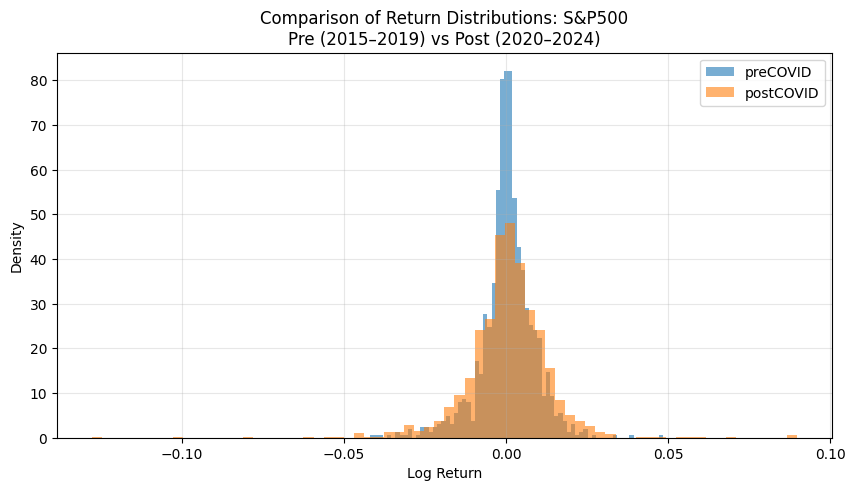

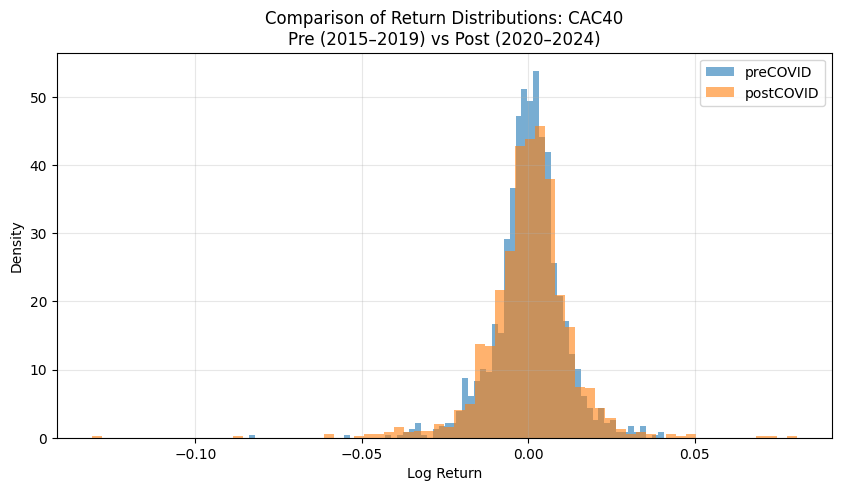

In [9]:
# Split periods: Pre-COVID (2015–2019) vs Post-COVID (2020–2024)
periods = {
    'preCOVID': ('2015-01-01', '2019-12-31'),
    'postCOVID': ('2020-01-01', '2024-12-31')
}

for name, df in data.items():
    plt.figure(figsize=(10,5))
    for period_name, (start, end) in periods.items():
        sub = df.loc[start:end, 'LogReturn']
        plt.hist(sub, bins=70, alpha=0.6, label=period_name, density=True)
    plt.title(f"Comparison of Return Distributions: {name}\nPre (2015–2019) vs Post (2020–2024)")
    plt.xlabel("Log Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    # plt.savefig(f"{name}_pre_post.png", dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
# Compute and compare volatilities between periods
for name, df in data.items():
    print(f"\n===== {name}: Annualized Volatility =====")
    for period_name, (start, end) in periods.items():
        sub = df.loc[start:end, 'LogReturn']
        vol = np.sqrt(252) * sub.std()
        print(f"{period_name}: {vol:.4f}")


===== S&P500: Annualized Volatility =====
preCOVID: 0.1346
postCOVID: 0.2143

===== CAC40: Annualized Volatility =====
preCOVID: 0.1685
postCOVID: 0.2057


In [11]:
# Correlation between S&P500 and CAC40 returns (overall + by period)
combined = pd.concat([
    data['S&P500']['LogReturn'],
    data['CAC40']['LogReturn']
], axis=1, keys=['S&P500', 'CAC40']).dropna()

print("\n===== Correlation between S&P500 and CAC40 =====")
print(f"Overall (2015–2024): {combined.corr().iloc[0,1]:.3f}")
for period_name, (start, end) in periods.items():
    corr = combined.loc[start:end].corr().iloc[0,1]
    print(f"{period_name}: {corr:.3f}")


===== Correlation between S&P500 and CAC40 =====
Overall (2015–2024): 0.569
preCOVID: 0.562
postCOVID: 0.581


## 2. Correcting for autocorrelation in volatility tests

In [14]:
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from math import sqrt


=== S&P500: ACF of squared returns ===
lag  1:  0.4830
lag  2:  0.5307
lag  3:  0.3337
lag  4:  0.3234
lag  5:  0.3174
lag  6:  0.3750
lag  7:  0.2742
lag  8:  0.3213
lag  9:  0.2533
lag 10:  0.2408

=== S&P500: Ljung-Box on squared returns ===
 lag     lb_stat     lb_pvalue
   1  587.107884 1.066565e-129
   5 2094.492805  0.000000e+00
  10 3207.853997  0.000000e+00
  20 3744.514215  0.000000e+00


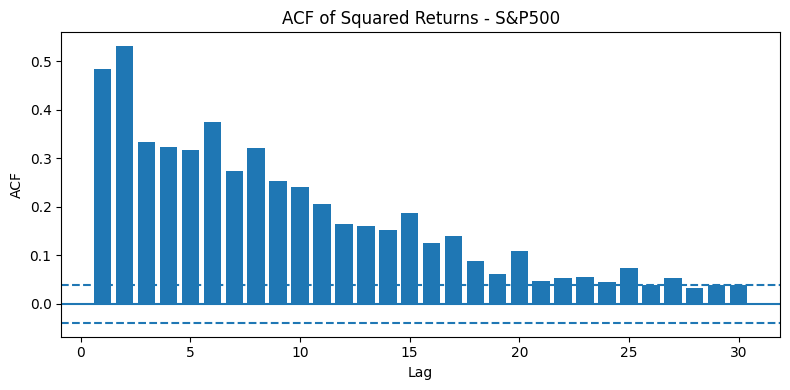


=== CAC40: ACF of squared returns ===
lag  1:  0.1101
lag  2:  0.1880
lag  3:  0.3262
lag  4:  0.2353
lag  5:  0.1257
lag  6:  0.1833
lag  7:  0.1310
lag  8:  0.2473
lag  9:  0.1794
lag 10:  0.1180

=== CAC40: Ljung-Box on squared returns ===
 lag     lb_stat     lb_pvalue
   1   31.058723  2.503387e-08
   5  576.809059 2.070752e-122
  10  982.547798 1.074195e-204
  20 1169.659626 2.300730e-235


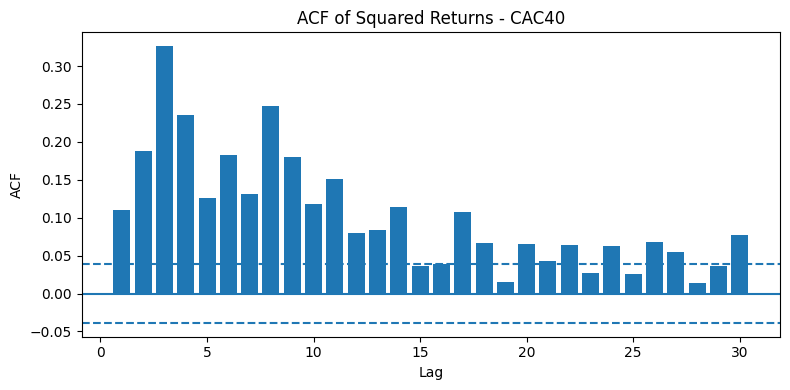

In [15]:
# 1) ACF computation
def compute_acf(x, max_lag):
    """
    Compute the sample ACF up to max_lag (including lag 0) without external stats helpers.
    x: 1D array-like
    Returns: np.ndarray of length max_lag+1 with rho[0] = 1
    """
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    n = x.shape[0]
    if n < max_lag + 1:
        raise ValueError("Series is too short for the requested max_lag.")       

    # Variance proxy (autocovariance at lag 0)
    gamma0 = np.dot(x, x) / n
    if gamma0 == 0:
        # Constant series: undefined ACF beyond lag 0; return zeros except rho[0]=1
        rho = np.zeros(max_lag + 1)
        rho[0] = 1.0
        return rho

    rho = np.empty(max_lag + 1, dtype=float)
    rho[0] = 1.0

    for k in range(1, max_lag + 1):
        # gamma_k = sum_{t=k..n-1} x_t * x_{t-k} / denom
        num = np.dot(x[k:], x[:-k])
        denom = n - k
        gamma_k = num / denom
        rho[k] = gamma_k / gamma0

    return rho

# 2) Ljung–Box test 
def ljung_box_test(x, lags):
    """
    Compute Ljung–Box Q statistics for the given set of lags.
    Uses the ACF estimated by compute_acf.
    Returns: pandas.DataFrame with columns: lag, lb_stat, lb_pvalue
    """
    x = np.asarray(x, dtype=float)
    n = x.shape[0]
    max_lag = int(np.max(lags))
    rho = compute_acf(x, max_lag=max_lag)

    # Q(m) = n(n+2) * sum_{k=1..m} (rho_k^2 / (n-k))
    Q_vals = []
    for m in lags:
        m = int(m)
        acc = 0.0
        for k in range(1, m + 1):
            acc += (rho[k] ** 2) / (n - k)
        Qm = n * (n + 2) * acc
        Q_vals.append(Qm)

    # Compute p-values with chi-square distribution
    pvals = []      
    for Qm, m in zip(Q_vals, lags):
        pvals.append(stats.chi2.sf(Qm, df=int(m)))   # Survival function

    out = pd.DataFrame({"lag": lags, "lb_stat": Q_vals, "lb_pvalue": pvals})
    return out

# 3) ACF plot
def plot_acf(x, max_lag=30, title="ACF", figsize=(8, 4)):
    """
    Draw the ACF bars for lags 1..max_lag and add ±1.96/sqrt(n) reference bands.
    """
    x = np.asarray(x, dtype=float)
    n = x.shape[0]
    rho = compute_acf(x, max_lag=max_lag)

    plt.figure(figsize=figsize)
    conf = 1.96 / sqrt(n)
    plt.axhline(0.0)
    plt.axhline(conf, linestyle="--")
    plt.axhline(-conf, linestyle="--")
    lags = np.arange(1, max_lag + 1)
    plt.bar(lags, rho[1:max_lag + 1], width=0.8, align="center")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.title(title)
    plt.tight_layout()
    # plt.savefig(f"{name}_ACF.png", dpi=300, bbox_inches='tight')
    plt.show()

# 4) Wrapper for squared returns
def show_squared_return_correlation(df, name, lags_to_show=10, lb_lags=(1, 5, 10, 20), acf_plot_lags=30):
    """
    Given a DataFrame with column 'LogReturn', this:
      - prints the first lags of the ACF of squared returns,
      - computes the Ljung–Box Q-statistics at selected lags,
      - and plots the ACF of squared returns.
    """
    r = df["LogReturn"].dropna().values
    r2 = r ** 2

    # Print ACF at the first few lags
    acf_vals = compute_acf(r2, max_lag=lags_to_show)
    print(f"\n=== {name}: ACF of squared returns ===")
    for k in range(1, lags_to_show + 1):
        print(f"lag {k:2d}: {acf_vals[k]: .4f}")

    # Ljung–Box Q-statistics
    lb = ljung_box_test(r2, lags=list(lb_lags))
    print(f"\n=== {name}: Ljung-Box on squared returns ===")
    print(lb.to_string(index=False))

    # Plot ACF
    plot_acf(r2, max_lag=acf_plot_lags, title=f"ACF of Squared Returns - {name}")

# 5) Usage for indexes
for name, df in data.items():
    show_squared_return_correlation(df, name, lags_to_show=10, lb_lags=(1,5,10,20), acf_plot_lags=30)

In [16]:
# Compute squared returns (volatility proxy)
for name, df in data.items():
    df["Volatility"] = df["LogReturn"]**2

# Run ADF test and print results
for name, df in data.items():
    for per, (start, end) in periods.items():
        x = df.loc[start:end, "Volatility"].dropna()
        adf_stat, pval, *_ = adfuller(x, autolag='AIC')
        print(f"{name} {per}: ADF stat = {adf_stat:.3f}, p-value = {pval}")

S&P500 preCOVID: ADF stat = -9.224, p-value = 1.7516832851600235e-15
S&P500 postCOVID: ADF stat = -5.944, p-value = 2.2304080287528021e-07
CAC40 preCOVID: ADF stat = -8.320, p-value = 3.586859809517114e-13
CAC40 postCOVID: ADF stat = -6.501, p-value = 1.161550962361604e-08


In [18]:
# Newey-West robust standard error for the mean
def newey_west_se(x, lag=None, kernel='bartlett'):
    """
    Compute the Newey-West standard error of the mean.
    Parameters
    ----------
    x : array-like
        Time series of data.
    lag : int
        Maximum lag truncation parameter (q). Default = floor(4*(n/100)**(2/9)).
    kernel : str
        Kernel type: 'bartlett' (default), 'rectangular', or 'parzen'.
    Returns
    -------
    se : float
        Robust standard error of the sample mean.
    """
    x = np.asarray(x)
    n = len(x)
    x = x - np.mean(x)  
    if lag is None:
        lag = int(np.floor(4 * (n / 100) ** (2 / 9)))   # Common rule of thumb

    # Compute autocovariances
    gamma = np.array([np.sum(x[:n - h] * x[h:]) / n for h in range(lag + 1)])
    
    # Define kernel weights
    if kernel == 'bartlett':
        w = 1 - np.arange(1, lag + 1) / (lag + 1)
    elif kernel == 'rectangular':
        w = np.ones(lag)
    elif kernel == 'parzen':
        h = np.arange(1, lag + 1) / (lag + 1)
        w = np.where(h <= 0.5, 1 - 6 * h ** 2 + 6 * np.abs(h) ** 3, 2 * (1 - np.abs(h)) ** 3)
    else:
        raise ValueError("Unknown kernel type")

    # Long-run variance estimate
    long_run_var = gamma[0] + 2 * np.sum(w * gamma[1:])
    
    # Robust standard error of the mean
    se = np.sqrt(long_run_var / n)
    return se

# Two-sample HAC t-test (pre vs post: periods are disjoint)
def robust_ttest_two_sample(x_pre, x_post, lag=None):
    """
    Two-sample test for equality of means with Newey–West SEs.
    Suitable when samples are from disjoint periods (no pairing).
    """
    x_pre = pd.Series(x_pre).dropna().to_numpy()
    x_post = pd.Series(x_post).dropna().to_numpy()
    n1, n2 = len(x_pre), len(x_post)
    m1, m2 = x_pre.mean(), x_post.mean()
    se1, se2 = newey_west_se(x_pre, lag), newey_west_se(x_post, lag)  
    se_diff = np.sqrt(se1**2 + se2**2)   # No cross term: periods are disjoint
    t_stat = (m1 - m2) / se_diff
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    return {"t_stat": t_stat, "mean_diff": m1 - m2, "se_diff": se_diff, "p_value": p_value, "n1": n1, "n2": n2}

# Paired HAC t-test (same dates: CAC40 vs S&P500)
def robust_ttest_paired(x1, x2, lag=None):
    """
    HAC one-sample t-test on D_t = x1_t - x2_t with inner-join on dates.
    Use when the two series refer to the same period (aligned by date).
    """
    df = pd.concat({'x1': x1, 'x2': x2}, axis=1).dropna()
    d = (df['x1'] - df['x2']).to_numpy()
    m = d.mean()
    se = newey_west_se(d, lag)
    t_stat = m / se
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    return {"t_stat": t_stat, "mean_diff": m, "se_diff": se, "p_value": p_value, "n": len(d)}

results = {}
# Pre vs Post (two samples, not paired)
for name, df in data.items():
    vol_pre  = df.loc[periods['preCOVID'][0]:periods['preCOVID'][1], 'Volatility']
    vol_post = df.loc[periods['postCOVID'][0]:periods['postCOVID'][1], 'Volatility']
    res = robust_ttest_two_sample(vol_pre, vol_post)
    print(f"\n=== {name} – Pre vs Post COVID ===")
    print(f"Mean diff: {res['mean_diff']:.6f}, SE: {res['se_diff']:.6f}")
    print(f"t (NW): {res['t_stat']:.3f}, p-value: {res['p_value']:.4f}  (n1={res['n1']}, n2={res['n2']})")

# France vs USA (paired, same period)
for period, (start, end) in periods.items():
    vol_cac = data['CAC40'].loc[start:end, 'Volatility']
    vol_sp  = data['S&P500'].loc[start:end, 'Volatility']
    res = robust_ttest_paired(vol_cac, vol_sp)
    print(f"\n=== {period} – CAC40 vs S&P500 ===")
    print(f"Mean diff: {res['mean_diff']:.6f}, SE: {res['se_diff']:.6f}")
    print(f"t (NW): {res['t_stat']:.3f}, p-value: {res['p_value']:.4f}  (n={res['n']})")


=== S&P500 – Pre vs Post COVID ===
Mean diff: -0.000110, SE: 0.000041
t (NW): -2.669, p-value: 0.0076  (n1=1257, n2=1257)

=== CAC40 – Pre vs Post COVID ===
Mean diff: -0.000055, SE: 0.000031
t (NW): -1.790, p-value: 0.0734  (n1=1276, n2=1282)

=== preCOVID – CAC40 vs S&P500 ===
Mean diff: 0.000044, SE: 0.000009
t (NW): 4.967, p-value: 0.0000  (n=1244)

=== postCOVID – CAC40 vs S&P500 ===
Mean diff: -0.000012, SE: 0.000018
t (NW): -0.685, p-value: 0.4934  (n=1247)


---
## Appendix 

### A.1. CLT and Slutsky’s theorem

In [21]:
# Two-sample classic t-test (pre vs post: periods are disjoint)
def ttest_two_sample(x_pre, x_post, lag=None):
    """
    Two-sample test for equality of means with classic SEs.
    Suitable when samples are from disjoint periods (no pairing).
    """
    x_pre = pd.Series(x_pre).dropna().to_numpy()
    x_post = pd.Series(x_post).dropna().to_numpy()
    n1, n2 = len(x_pre), len(x_post)
    m1, m2 = x_pre.mean(), x_post.mean()
    se1, se2 = x_pre.std() / sqrt(n1), x_post.std() / sqrt(n2)  
    se_diff = np.sqrt(se1**2 + se2**2)   
    t_stat = (m1 - m2) / se_diff
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    return {"t_stat": t_stat, "mean_diff": m1 - m2, "se_diff": se_diff, "p_value": p_value, "n1": n1, "n2": n2}

# Paired classic t-test (same dates: CAC40 vs S&P500)
def ttest_paired(x1, x2, lag=None):
    """
    One-sample t-test on D_t = x1_t - x2_t with inner-join on dates.
    Use when the two series refer to the same period (aligned by date).
    """
    df = pd.concat({'x1': x1, 'x2': x2}, axis=1).dropna()
    d = (df['x1'] - df['x2']).to_numpy()
    n = len(d)
    m = d.mean()
    se = d.std() / sqrt(n)
    t_stat = m / se
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    return {"t_stat": t_stat, "mean_diff": m, "se_diff": se, "p_value": p_value, "n": n}

results = {}
# Pre vs Post (two samples, not paired)
for name, df in data.items():
    vol_pre  = df.loc[periods['preCOVID'][0]:periods['preCOVID'][1], 'Volatility']
    vol_post = df.loc[periods['postCOVID'][0]:periods['postCOVID'][1], 'Volatility']
    res = ttest_two_sample(vol_pre, vol_post)
    print(f"\n=== {name} – Pre vs Post COVID ===")
    print(f"Mean diff: {res['mean_diff']:.6f}, SE: {res['se_diff']:.6f}")
    print(f"t: {res['t_stat']:.3f}, p-value: {res['p_value']:.4f}  (n1={res['n1']}, n2={res['n2']})")

# France vs USA (paired, same period)
for period, (start, end) in periods.items():
    vol_cac = data['CAC40'].loc[start:end, 'Volatility']
    vol_sp  = data['S&P500'].loc[start:end, 'Volatility']
    res = ttest_paired(vol_cac, vol_sp)
    print(f"\n=== {period} – CAC40 vs S&P500 ===")
    print(f"Mean diff: {res['mean_diff']:.6f}, SE: {res['se_diff']:.6f}")
    print(f"t: {res['t_stat']:.3f}, p-value: {res['p_value']:.4f}  (n={res['n']})")


=== S&P500 – Pre vs Post COVID ===
Mean diff: -0.000110, SE: 0.000021
t: -5.221, p-value: 0.0000  (n1=1257, n2=1257)

=== CAC40 – Pre vs Post COVID ===
Mean diff: -0.000055, SE: 0.000020
t: -2.725, p-value: 0.0064  (n1=1276, n2=1282)

=== preCOVID – CAC40 vs S&P500 ===
Mean diff: 0.000044, SE: 0.000008
t: 5.755, p-value: 0.0000  (n=1244)

=== postCOVID – CAC40 vs S&P500 ===
Mean diff: -0.000012, SE: 0.000017
t: -0.724, p-value: 0.4688  (n=1247)


### A.2. Lag truncation parameter selection

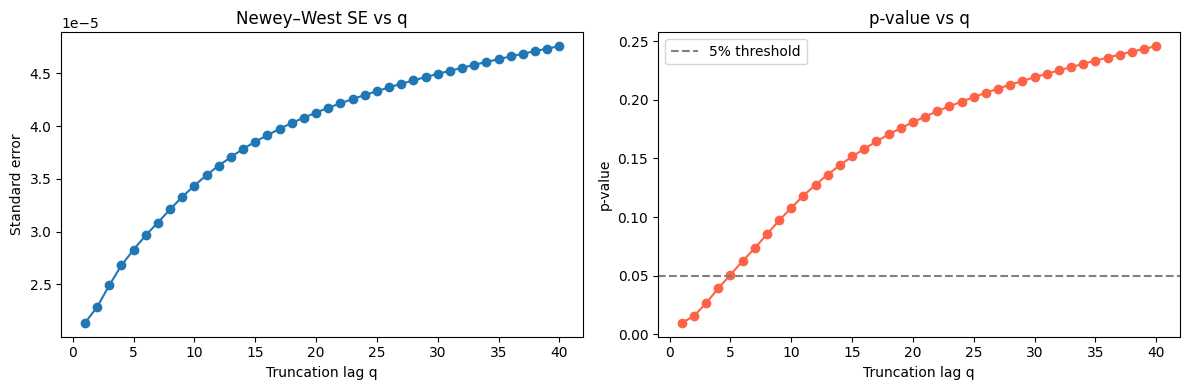

In [23]:
def analyze_q_effect(x1, x2=None, max_q=40, paired=False):
    """
    Show how the HAC standard error and p-value vary with the truncation lag q.
    - If paired=False → two-sample test (x1=pre, x2=post)
    - If paired=True  → paired test (same length series)
    """
    results = []
    qs = range(1, max_q + 1)

    for q in qs:
        if paired and x2 is not None:
            res = robust_ttest_paired(x1, x2, lag=q)
            label = "Paired"
        else:
            res = robust_ttest_two_sample(x1, x2, lag=q)
            label = "Two-sample"
        results.append({
            "q": q,
            "se": res["se_diff"],
            "t": res["t_stat"],
            "p": res["p_value"]
        })
    df = pd.DataFrame(results)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(df["q"], df["se"], marker="o")
    ax[0].set_title("Newey–West SE vs q")
    ax[0].set_xlabel("Truncation lag q")
    ax[0].set_ylabel("Standard error")

    ax[1].plot(df["q"], df["p"], marker="o", color="tomato")
    ax[1].axhline(0.05, color="gray", linestyle="--", label="5% threshold")
    ax[1].set_title("p-value vs q")
    ax[1].set_xlabel("Truncation lag q")
    ax[1].set_ylabel("p-value")
    ax[1].legend()
    plt.tight_layout()
    # plt.savefig("q_param.png", dpi=300, bbox_inches='tight')
    plt.show()

    return df

vol_pre  = data['CAC40'].loc[periods['preCOVID'][0]:periods['preCOVID'][1], 'Volatility']
vol_post = data['CAC40'].loc[periods['postCOVID'][0]:periods['postCOVID'][1], 'Volatility']

df_q = analyze_q_effect(vol_pre, vol_post, max_q=40, paired=False)